# MultiREx Autoencoder for Exoplanet Spectra Denoising (H2O)

This script trains a deep learning model to remove noise and stellar contamination
from exoplanet transit spectra. This version is fully optimized for memory efficiency
on both CPU and GPU.


## Initial Setup and Imports


In [1]:
import multirex as mrex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import gc
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



def remove_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    # Ignore warnings from the custom attributes in pandas
    warnings.filterwarnings(
        "ignore",
        category=UserWarning,
        message="Pandas doesn't allow columns to be created via a new attribute name*",
    )



# Initial setup
remove_warnings()
waves = np.loadtxt("waves.txt")
n_points = len(waves)
indices = np.linspace(0, len(waves) - 1, n_points, endpoint=True)
indices = np.round(indices).astype(int)  # Redondear los índices y convertir a entero

# Seleccionar los elementos de la lista usando los índices
puntos_seleccionados = waves[indices]
waves = puntos_seleccionados
wn_grid = np.sort((10000 / waves))

Numba not installed, using numpy instead
Loading MultiREx version 0.3.2


## Load Data


In [2]:
def apply_contaminations_from_files(contamination_files, df, n_points):
    """
    Applies multiple contaminations to the data from a list of contamination files
    and returns a DataFrame with all combinations, including the non-contaminated case.

    Parameters:
        contamination_files (list of str): Paths to .txt files containing contaminations.
        df (pandas.DataFrame): Original DataFrame to apply contaminations.
        n_points (int): Number of columns to which the contamination will be applied.

    Returns:
        pandas.DataFrame: DataFrame with all combinations of contaminations, including the
        non-contaminated case, with additional columns 'f_spot' and 'f_fac'.
    """

    # This version is optimized to prevent DataFrame fragmentation.

    df_list = []
    # Non-contaminated case: create a copy and add f_spot and f_fac as 0.0
    df_no_contam = df.copy()
    # Use assign to create new columns efficiently
    df_no_contam = df_no_contam.assign(f_spot=0.0, f_fac=0.0)
    # Reorder
    cols = ["f_spot", "f_fac"] + [
        col for col in df.columns if col not in ["f_spot", "f_fac"]
    ]
    df_no_contam = df_no_contam[cols]
    df_list.append(df_no_contam)

    pattern = r"fspot(?P<f_spot>[0-9.]+)_ffac(?P<f_fac>[0-9.]+)\.txt$"

    for file_path in contamination_files:
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"The file {file_path} does not exist.")

        filename = os.path.basename(file_path)
        match = re.search(pattern, filename)
        if not match:
            raise ValueError(
                f"The file name '{filename}' does not match the expected pattern."
            )

        f_spot = float(match.group("f_spot"))
        f_fac = float(match.group("f_fac"))

        try:
            contamination_data = np.loadtxt(file_path, ndmin=2)
            contam_values = (
                contamination_data[:, 1]
                if contamination_data.shape[1] >= 2
                else contamination_data.flatten()
            )
            if len(contam_values) != n_points:
                raise ValueError(
                    f"Contamination values in '{filename}' ({len(contam_values)}) != n_points ({n_points})."
                )
        except Exception as e:
            raise ValueError(f"Error reading the file {file_path}: {e}")

        contam_values = contam_values[::-1]

        df_contam = df.copy()
        data_columns = df_contam.columns[-n_points:]

        # Perform multiplication
        df_contam[data_columns] = df_contam[data_columns].multiply(
            contam_values, axis=1
        )

        # Create new columns efficiently using assign
        df_contam = df_contam.assign(f_spot=f_spot, f_fac=f_fac)

        # Reorder columns
        cols = ["f_spot", "f_fac"] + [
            col for col in df.columns if col not in ["f_spot", "f_fac"]
        ]
        df_contam = df_contam[cols]
        df_list.append(df_contam)

    df_final = pd.concat(
        df_list, ignore_index=True
    ).copy()  # .copy() ensures a de-fragmented frame
    df_final.data = df_final.iloc[:, -n_points:]
    df_final.params = df_final.iloc[:, :-n_points]
    return df_final

In [3]:
contamination_files = [
    "stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.08.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.54.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.70.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.08.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.54.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.70.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.08.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.54.txt",
    "stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.70.txt",
]


def filter_rows(df):
    """
    Filters rows of a DataFrame where at least one of the columns
    "atm CH4", "atm O3", or "atm H2O" has a value >= -8.
    Returns the DataFrame unchanged if none of these columns are present.
    """
    filter_columns = ["atm CH4", "atm O3", "atm H2O"]
    present_columns = [col for col in filter_columns if col in df.columns]

    for chem in present_columns:
        df = df[df[chem] >= -8]
        # Set .data and .params attributes on the final DataFrame
    df.data = df.iloc[:, -n_points:]
    df.params = df.iloc[:, :-n_points]
    return df


# Helper function to load data and correctly set dtypes
def load_and_prep_data(filepath, n_points):
    """Reads a CSV and converts only the spectral data columns to float32."""
    df = pd.read_csv(filepath)
    # Identify spectral data columns (last n_points)
    data_cols = df.columns[-n_points:]
    # Convert only spectral data to float32, leave params as they are
    df[data_cols] = df[data_cols].astype("float32")
    return df


try:
    airless_data = load_and_prep_data("spec_data/airless_data.csv", n_points)
    airless_data = apply_contaminations_from_files(
        contamination_files, airless_data, n_points
    )

    CO2_data = load_and_prep_data("spec_data/CO2_data.csv", n_points)
    CO2_data = apply_contaminations_from_files(contamination_files, CO2_data, n_points)

    H2O_data = load_and_prep_data("spec_data/H2O_data.csv", n_points)
    H2O_data = filter_rows(H2O_data)
    H2O_data = apply_contaminations_from_files(contamination_files, H2O_data, n_points)
except Exception as e:
    print(f"Error processing initial data: {e}")

## Clean data


In [4]:
def mult_df(df, n_points, n_mult):
    df_list = []
    for _ in range(n_mult + 1):
        df_no_contam = df.copy()
        # Use assign to avoid fragmentation
        df_no_contam = df_no_contam.assign(f_spot=0.0, f_fac=0.0)
        cols = ["f_spot", "f_fac"] + [
            col for col in df.columns if col not in ["f_spot", "f_fac"]
        ]
        df_no_contam = df_no_contam[cols]
        df_list.append(df_no_contam)

    df_final = pd.concat(df_list, ignore_index=True).copy()  # .copy() de-fragments
    df_final.data = df_final.iloc[:, -n_points:]
    df_final.params = df_final.iloc[:, :-n_points]
    return df_final

In [5]:
try:
    airless_data_clean = load_and_prep_data("spec_data/airless_data.csv", n_points)
    airless_data_clean = mult_df(airless_data_clean, n_points, 9)

    CO2_data_clean = load_and_prep_data("spec_data/CO2_data.csv", n_points)
    CO2_data_clean = mult_df(CO2_data_clean, n_points, 9)

    H2O_data_clean = load_and_prep_data("spec_data/H2O_data.csv", n_points)
    H2O_data_clean = filter_rows(H2O_data_clean)
    H2O_data_clean = mult_df(H2O_data_clean, n_points, 9)
except Exception as e:
    print(f"Error processing clean data: {e}")

In [6]:
def normalize_min_max_by_row(df):
    min_by_row = df.min(axis=1)
    max_by_row = df.max(axis=1)
    range_by_row = max_by_row - min_by_row
    # Avoid division by zero
    range_by_row[range_by_row == 0] = 1
    normalized = (df.sub(min_by_row, axis=0)).div(range_by_row, axis=0)
    return normalized

# Noisy and Clean


In [7]:
def normalize_min_max_by_row(df):
    min_by_row = df.min(axis=1)
    max_by_row = df.max(axis=1)
    range_by_row = max_by_row - min_by_row
    # Avoid division by zero
    range_by_row[range_by_row == 0] = 1
    normalized = (df.sub(min_by_row, axis=0)).div(range_by_row, axis=0)
    return normalized


def generate_df_with_noise_std(df, n_repeat, noise_std, seed=None):
    if not hasattr(df, "params"):
        df_params = pd.DataFrame()
        if not hasattr(df, "data"):
            df_spectra = df
    else:
        if not hasattr(df, "data"):
            raise ValueError("The DataFrame must have a 'data' attribute.")
        df_params = df.params
        df_spectra = df.data

    df_spectra = df_spectra.astype("float32")

    if seed is not None:
        np.random.seed(seed)

    df_spectra_replicated = pd.DataFrame(
        np.repeat(df_spectra.values, n_repeat, axis=0),
        columns=df_spectra.columns,
    )

    if isinstance(noise_std, (int, float)):
        noise_replicated = np.full(
            df_spectra_replicated.shape, noise_std, dtype="float32"
        )
    else:
        noise_array = np.array(noise_std, dtype="float32")
        noise_replicated = np.repeat(noise_array[:, np.newaxis], n_repeat, axis=0)
        noise_replicated = np.tile(
            noise_replicated, (1, df_spectra_replicated.shape[1])
        )

    gaussian_noise = np.random.normal(
        0, noise_replicated, df_spectra_replicated.shape
    ).astype("float32")
    df_spectra_replicated += gaussian_noise

    df_params_replicated = pd.DataFrame(
        np.repeat(df_params.values, n_repeat, axis=0),
        columns=df_params.columns,
    )

    # Efficiently add new columns
    new_cols_data = {
        "noise_std": (
            np.repeat(noise_std, n_repeat)
            if isinstance(noise_std, (list, np.ndarray, pd.Series))
            else noise_std
        ),
        "n_repeat": n_repeat,
    }
    new_cols_df = pd.DataFrame(new_cols_data, index=df_params_replicated.index)

    # Concatenate all parts at once
    df_final = pd.concat(
        [
            new_cols_df,
            df_params_replicated.reset_index(drop=True),
            df_spectra_replicated.reset_index(drop=True),
        ],
        axis=1,
    )

    df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
    df_final.params = df_final.iloc[:, : -df_spectra_replicated.shape[1]]

    return df_final

### OPTIMIZED: Generate and Process All Data

This single cell replaces all the individual SNR cells and the final `## Data` cell.
It loops through each SNR value, generates the noisy and clean data, normalizes it,
appends the result to a list as a NumPy array, and then clears the memory.
This avoids holding multiple massive dataframes in memory at once.


## Data


### opt snr and noisy


In [8]:
import os

# Define file paths for the cached numpy arrays in a dedicated directory
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
noisy_path = os.path.join(output_dir, "H2O_noisy_full_dataset.npy")
clean_path = os.path.join(output_dir, "H2O_clean_full_dataset.npy")

# Caching Logic: Check if files exist
if os.path.exists(noisy_path) and os.path.exists(clean_path):
    print("Found cached data. Loading from disk...")
    X_noisy = np.load(noisy_path)
    X_no_noisy = np.load(clean_path)
    print("...Loading complete.")
    print(f"Loaded noisy data shape: {X_noisy.shape}")
    print(f"Loaded clean data shape: {X_no_noisy.shape}")

else:
    print("Cached data not found. Starting data generation process...")

    list_of_noisy_arrays = []
    list_of_clean_arrays = []

    # Using None for the 'Nan' (no noise) case
    snr_values = [1, 3, 6, 10, None]

    for snr in snr_values:
        print(
            f"--- Processing SNR = {snr if snr is not None else 'inf (no additional noise)'} ---"
        )
        gc.collect()

        # --- Generate Noisy Data (Contaminated + Noise) ---
        if snr is not None:
            noise = mrex.generate_df_SNR_noise(df=CO2_data, n_repeat=1, SNR=snr)[
                "noise"
            ][0]
        else:
            noise = 0.0  # No additional noise for the "Nan" case

        temp_CO2_data = generate_df_with_noise_std(
            df=CO2_data, n_repeat=5000, noise_std=noise
        )
        temp_H2O_data = generate_df_with_noise_std(
            df=H2O_data, n_repeat=500, noise_std=noise
        )
        temp_airless_data = generate_df_with_noise_std(
            df=airless_data, n_repeat=5000, noise_std=noise
        )

        current_noisy_df = pd.concat(
            [temp_CO2_data, temp_H2O_data, temp_airless_data], ignore_index=True
        )

        normalized_data = normalize_min_max_by_row(current_noisy_df.iloc[:, -n_points:])
        list_of_noisy_arrays.append(normalized_data.values.astype("float32"))

        del (
            temp_CO2_data,
            temp_H2O_data,
            temp_airless_data,
            current_noisy_df,
            normalized_data,
        )
        gc.collect()

        # --- Generate Corresponding Clean Data (Uncontaminated + No Noise) ---
        temp_no_CO2_data = generate_df_with_noise_std(
            df=CO2_data_clean, n_repeat=5000, noise_std=0
        )
        temp_no_H2O_data = generate_df_with_noise_std(
            df=H2O_data_clean, n_repeat=500, noise_std=0
        )
        temp_no_airless_data = generate_df_with_noise_std(
            df=airless_data_clean, n_repeat=5000, noise_std=0
        )

        current_clean_df = pd.concat(
            [temp_no_CO2_data, temp_no_H2O_data, temp_no_airless_data],
            ignore_index=True,
        )

        normalized_data = normalize_min_max_by_row(current_clean_df.iloc[:, -n_points:])
        list_of_clean_arrays.append(normalized_data.values.astype("float32"))

        del (
            temp_no_CO2_data,
            temp_no_H2O_data,
            temp_no_airless_data,
            current_clean_df,
            normalized_data,
        )
        gc.collect()

    print("\n--- Final Data Concatenation ---")
    X_noisy = np.concatenate(list_of_noisy_arrays, axis=0)
    del list_of_noisy_arrays

    X_no_noisy = np.concatenate(list_of_clean_arrays, axis=0)
    del list_of_clean_arrays

    gc.collect()

    print("\n--- Saving generated data to disk for future runs ---")
    np.save(noisy_path, X_noisy)
    np.save(clean_path, X_no_noisy)
    print(f"Data saved to directory: '{output_dir}'")

    print(f"\nFinal noisy data shape: {X_noisy.shape}")
    print(f"Final clean data shape: {X_no_noisy.shape}")
    assert (
        X_noisy.shape[0] == X_no_noisy.shape[0]
    ), "The number of samples does not match."

Cached data not found. Starting data generation process...
--- Processing SNR = 1 ---


/tmp/ipykernel_9153/3730270624.py:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
/tmp/ipykernel_9153/3730270624.py:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.params = df_final.iloc[:, : -df_spectra_replicated.shape[1]]
/tmp/ipykernel_9153/3730270624.py:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
/tmp/ipykernel_9153/3730270624.py:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#a

--- Processing SNR = 3 ---


/tmp/ipykernel_9153/3730270624.py:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
/tmp/ipykernel_9153/3730270624.py:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.params = df_final.iloc[:, : -df_spectra_replicated.shape[1]]
/tmp/ipykernel_9153/3730270624.py:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
/tmp/ipykernel_9153/3730270624.py:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#a

--- Processing SNR = 6 ---


/tmp/ipykernel_9153/3730270624.py:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
/tmp/ipykernel_9153/3730270624.py:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.params = df_final.iloc[:, : -df_spectra_replicated.shape[1]]
/tmp/ipykernel_9153/3730270624.py:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
/tmp/ipykernel_9153/3730270624.py:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#a

--- Processing SNR = 10 ---


/tmp/ipykernel_9153/3730270624.py:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
/tmp/ipykernel_9153/3730270624.py:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.params = df_final.iloc[:, : -df_spectra_replicated.shape[1]]
/tmp/ipykernel_9153/3730270624.py:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
/tmp/ipykernel_9153/3730270624.py:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#a

--- Processing SNR = inf (no additional noise) ---


/tmp/ipykernel_9153/3730270624.py:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
/tmp/ipykernel_9153/3730270624.py:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.params = df_final.iloc[:, : -df_spectra_replicated.shape[1]]
/tmp/ipykernel_9153/3730270624.py:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1] :]
/tmp/ipykernel_9153/3730270624.py:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#a


--- Final Data Concatenation ---

--- Saving generated data to disk for future runs ---
Data saved to directory: 'processed_data'

Final noisy data shape: (1600000, 385)
Final clean data shape: (1600000, 385)


### FInal data


### Final data prep and Model Training

The rest of your script remains the same.


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Set memory growth to True for all GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Set memory growth for {len(gpus)} GPU(s)")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2025-08-09 18:52:57.246771: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-09 18:52:57.350101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754754777.388867    9153 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754754777.400469    9153 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754754777.472256    9153 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Set memory growth for 1 GPU(s)


In [10]:
test_size = 0.2

X_train_noisy, X_test_noisy, X_train_clean, X_test_clean = train_test_split(
    X_noisy, X_no_noisy, test_size=test_size, random_state=42
)
del (X_noisy, X_no_noisy)
gc.collect()

0

In [11]:

# Your batch size from the fit command
batch_size = 64 

with tf.device('/CPU:0'):
    # Create a training dataset from your numpy arrays
    tf_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_noisy, X_train_clean))
    
    # Create a validation dataset
    tf_val_dataset = tf.data.Dataset.from_tensor_slices((X_test_noisy, X_test_clean))

# Now, configure the datasets for performance (shuffling, batching, etc.)
tf_train_dataset = tf_train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# IMPORTANT: Clean up the huge numpy arrays to free RAM
del X_train_noisy, X_train_clean, X_test_noisy, X_test_clean
gc.collect()

print("TensorFlow datasets created on CPU and NumPy arrays removed from RAM.")

I0000 00:00:1754754804.176994    9153 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1898 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


TensorFlow datasets created on CPU and NumPy arrays removed from RAM.


### Dense Autoencoder


In [12]:
# input_dim = X_train_noisy.shape[1]
input_dim = tf_train_dataset.element_spec[0].shape[1]

input_spectrum = keras.Input(shape=(input_dim,))

# Encoder
encoded = layers.Dense(512, activation="swish")(input_spectrum)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(512, activation="swish")(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(512, activation="swish")(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(300, activation="swish")(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(300, activation="swish")(encoded)
encoded = layers.Dropout(0.2)(encoded)

# Decoder
decoded = layers.Dense(300, activation="swish")(encoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(300, activation="swish")(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(512, activation="swish")(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(512, activation="swish")(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(512, activation="swish")(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(input_dim, activation="linear")(decoded)

autoencoder = keras.Model(inputs=input_spectrum, outputs=decoded)
optimizer = Adam(learning_rate=0.00001)
autoencoder.compile(optimizer=optimizer, loss="mae")

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 385)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │       153,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       154,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 385)            │       197,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,024,673 (7.72 MB)

 Trainable params: 2,024,673 (7.72 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = autoencoder.fit(
    tf_train_dataset,  # Pass the training dataset
    epochs=100,
    validation_data=tf_val_dataset,  # Pass the validation dataset
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
    ],
)

# Save the trained model
autoencoder.save("Models/AE_H2O.keras")


Epoch 1/100


I0000 00:00:1754754827.679597   12479 service.cc:152] XLA service 0x7fcb94016df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754754827.679711   12479 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-08-09 18:53:47.767179: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754754828.278149   12479 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-09 18:53:50.171322: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4124', 140 bytes spill stores, 140 bytes spill loads

2025-08-09 18:53:50.412553: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

   28/20000 ━━━━━━━━━━━━━━━━━━━━ 1:55 6ms/step - loss: 0.1694  

I0000 00:00:1754754835.352752   12479 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - loss: 0.0744 - val_loss: 0.0295
Epoch 2/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.0343 - val_loss: 0.0203
Epoch 3/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - loss: 0.0229 - val_loss: 0.0121
Epoch 4/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - loss: 0.0179 - val_loss: 0.0102
Epoch 5/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - loss: 0.0164 - val_loss: 0.0096
Epoch 6/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 0.0155 - val_loss: 0.0095
Epoch 7/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 0.0148 - val_loss: 0.0088
Epoch 8/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0143 - val_loss: 0.0083
Epoch 9/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.0137 - val_loss: 0.0076
Epoch 10/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.0131 - val_loss: 0.0073
Epoch 11/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - loss: 0.0125 - val_loss: 0.006

Loading test data for final evaluation...
Test data re-loaded successfully.

Plotting training history...


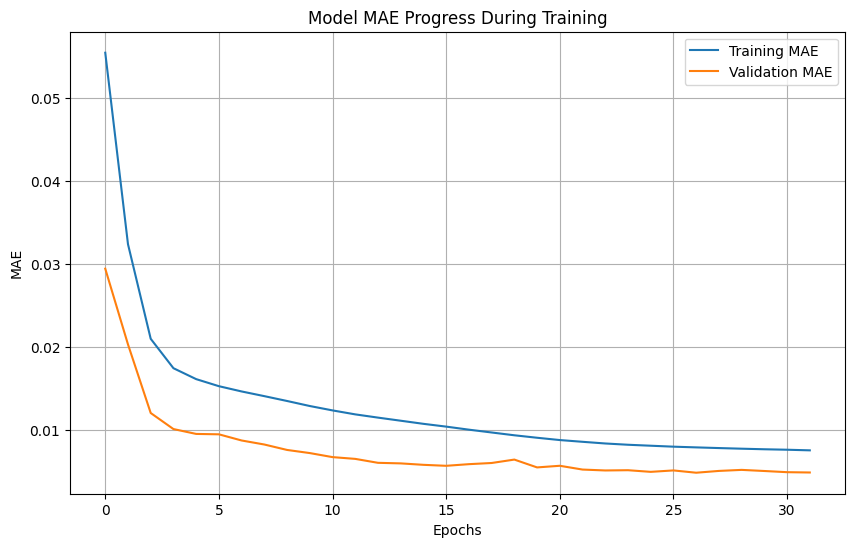


Predicting on test data...
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Visualizing sample reconstructions...


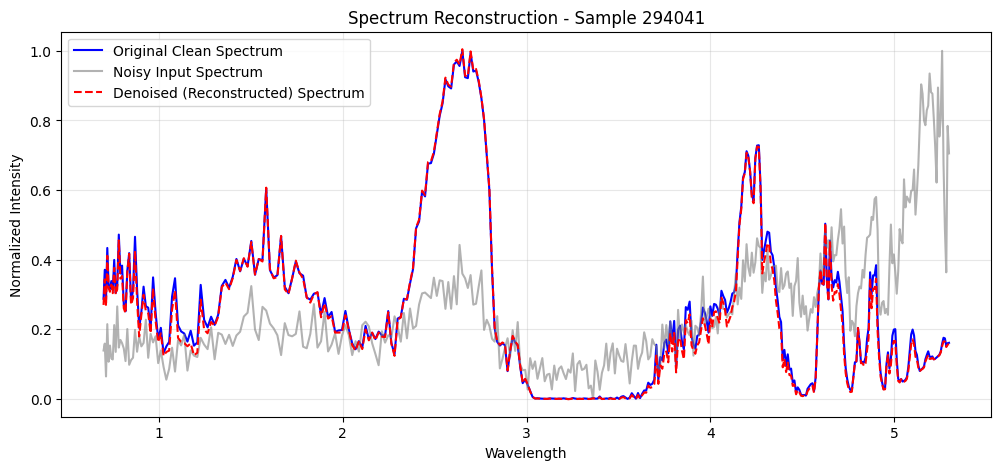

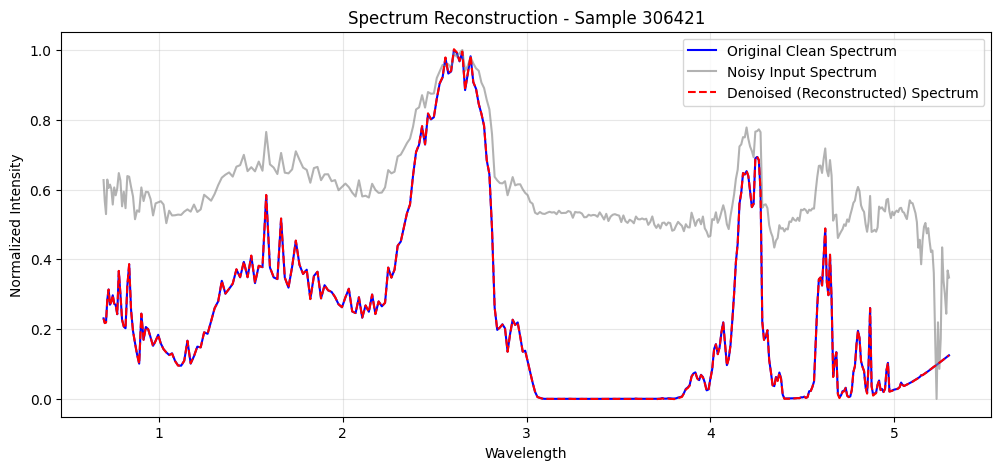

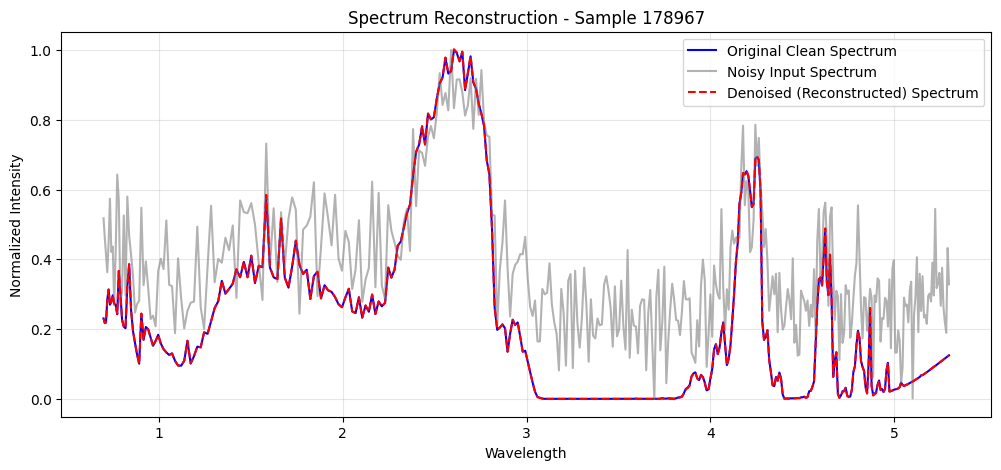

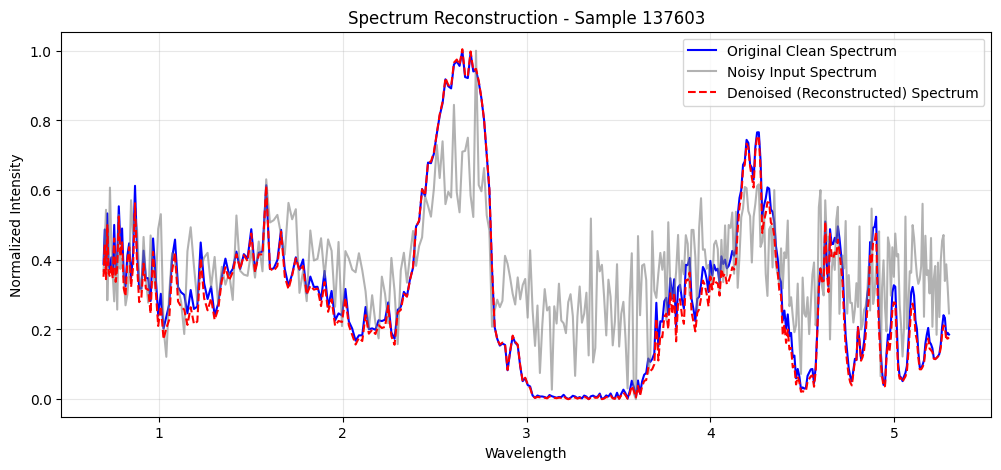

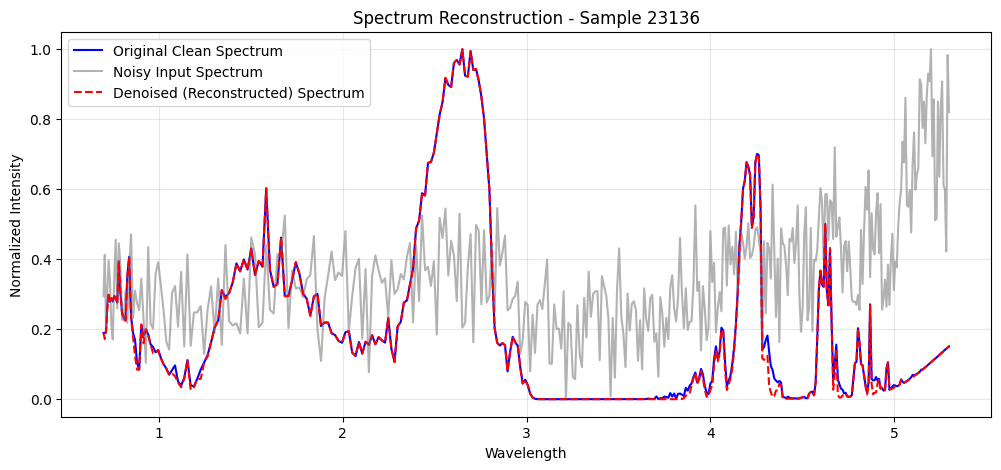


Calculating final performance metrics...
Final Mean Absolute Error (MAE): 0.004899
Final Mean Squared Error (MSE): 0.000566
Final Coefficient of Determination (R²): 0.988997


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import gc


saved_autoencoder = keras.models.load_model("Models/AE_H2O.keras")


# Define constants again to make this cell self-contained
TEST_SIZE = 0.2
RANDOM_STATE = 42
BATCH_SIZE = 64

print("Loading test data for final evaluation...")
X_noisy_full = np.load(noisy_path)
X_clean_full = np.load(clean_path)

# Perform the exact same train-test split to get the identical test set
# Using the same RANDOM_STATE is crucial here.
_, X_test_noisy, _, X_test_clean = train_test_split(
    X_noisy_full, X_clean_full, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# We can now delete the full arrays again as we only need the test set
del X_noisy_full, X_clean_full
gc.collect()
print("Test data re-loaded successfully.")

# Plot training and validation MAE
# This assumes 'history' object is still available from the training cell
print("\nPlotting training history...")
if 'history' in locals():
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Training MAE")
    plt.plot(history.history["val_loss"], label="Validation MAE")
    plt.title("Model MAE Progress During Training")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Training history not available to plot.")


# Predict reconstructed spectra on test data
print("\nPredicting on test data...")
decoded_spectra = autoencoder.predict(X_test_noisy, batch_size=BATCH_SIZE)


# Visualize a few reconstructions
print("Visualizing sample reconstructions...")
num_samples = 5  # Number of samples to visualize
indices = np.random.choice(len(X_test_noisy), num_samples, replace=False)

for idx in indices:
    plt.figure(figsize=(12, 5))
    plt.plot(waves, X_test_clean[idx].flatten(), label="Original Clean Spectrum", color='blue')
    plt.plot(waves, X_test_noisy[idx].flatten(), label="Noisy Input Spectrum", color='gray', alpha=0.6)
    plt.plot(
        waves,
        decoded_spectra[idx].flatten(),
        label="Denoised (Reconstructed) Spectrum",
        linestyle="--",
        color='red'
    )
    plt.xlabel("Wavelength")
    plt.ylabel("Normalized Intensity")
    plt.title(f"Spectrum Reconstruction - Sample {idx}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# %% [markdown]
# ### Final Performance Metrics

# %%
print("\nCalculating final performance metrics...")
mae = mean_absolute_error(X_test_clean, decoded_spectra)
print(f"Final Mean Absolute Error (MAE): {mae:.6f}")

mse = mean_squared_error(X_test_clean, decoded_spectra)
print(f"Final Mean Squared Error (MSE): {mse:.6f}")

# Flatten for R² score
r2 = r2_score(X_test_clean.flatten(), decoded_spectra.flatten())
print(f"Final Coefficient of Determination (R²): {r2:.6f}")


# Eval


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Re-load the best model saved by EarlyStopping
autoencoder = keras.models.load_model("Models/AE_H2O_OG.keras")
X_reconstructed = autoencoder.predict(X_test_noisy)

# Compute evaluation metrics on the test set
mae = mean_absolute_error(X_test_clean, X_reconstructed)
print(f"Mean Absolute Error (MAE): {mae:.6f}")

mse = mean_squared_error(X_test_clean, X_reconstructed)
print(f"Mean Squared Error (MSE): {mse:.6f}")

r2 = r2_score(X_test_clean.flatten(), X_reconstructed.flatten())
print(f"Coefficient of Determination (R²): {r2:.6f}")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 9s 919us/step
Mean Absolute Error (MAE): 0.005317
Mean Squared Error (MSE): 0.000874
Coefficient of Determination (R²): 0.983009
